# 画像データを行列計算可能な形で取得

In [8]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (H + 2*pad - filter_w) // stride + 1
    
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [9]:
import sys, os
sys.path.append(os.pardir)
import numpy as np

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)



(9, 75)


In [10]:
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)


(90, 75)


In [12]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (H + 2*pad - filter_w) // stride + 1
    col = col.shape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
            
    return img[:, :, pad:H + pad, pad:W + pad]

# 畳み込みレイヤーの実装

In [13]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int( (H + 2*self.pad - FH) // self.stride + 1)
        out_w = int( (H + 2*self.pad - FW) // self.stride + 1)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).tranpose(0, 3, 1, 2)
        
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.tranpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stribe, self.pad)
        
        return dx

In [14]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int( 1 + (H - self.pool_h) / self.stride)
        out_w = int( 1 + (H - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        out = np.max(col, axis=1)
        
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arrange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

# SimpleConvNetの実装

In [39]:
from collections import OrderedDict
from common.layers import *

class SimpleConvNet:
    
    def __init__(self, input_dim=(1, 28, 28),
                conv_param={'filter_num':30, 'filter_size':5,
                           'pad':0, 'stribe':1},
                hidden_size = 100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stribe = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stribe + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        
        self.last_layer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)
        
        return acc / x.shape[0]
    
    def gradient(self, x, t):
        self.loss(x, t)
        
        dout =1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        
        return grads

# 動作確認

train loss:2.29993696589
=== epoch:1, train acc:0.14, test acc:0.165 ===
train loss:2.29717100526
train loss:2.2944046537
train loss:2.28767349866
train loss:2.28033135279
train loss:2.26704024417
train loss:2.25749764204
train loss:2.24049559927
train loss:2.21821033277
train loss:2.20644971278
train loss:2.1745852206
train loss:2.13560018154
train loss:2.07765281076
train loss:2.04075207727
train loss:1.97449239429
train loss:1.96120903056
train loss:1.91139548463
train loss:1.82502189589
train loss:1.75965028629
train loss:1.62945909698
train loss:1.48345304368
train loss:1.50533188447
train loss:1.43209258693
train loss:1.35092413638
train loss:1.30974600368
train loss:1.13756323075
train loss:1.01462693371
train loss:1.07021044927
train loss:0.943368370901
train loss:0.902110550837
train loss:0.912288658573
train loss:0.794591889888
train loss:0.86711345809
train loss:0.715325636843
train loss:0.675565073459
train loss:0.754076855681
train loss:0.718836179944
train loss:0.73084224

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


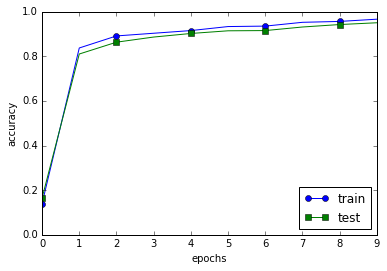

In [43]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer
%matplotlib inline

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 10

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
#network.save_params("params.pkl")
#print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()